In [4]:
import requests as rq
from io import BytesIO # 파일 시스템에 접근하지 않고 메모리 스트림 다루기 위함
import pandas as pd
import datetime
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# generate 헤더 요청 URL
url = "http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd"


# generate 페이로드의 양식 데이터
data = {
    "locale": "ko_KR",
    "mktId": "ALL",
    "share": "1",
    "csvxls_isNo": "false",
    "name": "fileDown",
    "url": "dbms/MDC/STAT/standard/MDCSTAT01901",
}

In [6]:
# 브라우저에서 서버로 보내는 헤더값
# referer: 해당 요청이 어디에서 발생했는지 나타냄 (사이트로의 접근을 알림)
# user-agent: 사용자 소프트웨어의 식별 정보 (Mozilla 정보/버전 + 운영체제 정보 + 렌더링 엔진 정보 + 브라우저)

headers = {
    "Referer": "http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36"
}

In [7]:
# generate 부분의 헤더에서 Referer과 User-Agent를 따올 수 있음 User-Agent는 모두 동일
# KRX의 다른 정보를 따올 때는 Referer만 바꿔주기
# download payload(요청데이터)와 동일해야함


otp = rq.post(url=url, data=data, headers=headers).text

In [8]:
otp

'/cDCPfFdI0WBIOM8t1/9OXG8p12P2J7PRD2Lk0zG/OsRtSksuLS7Bnxpl86F7dAOvXfGx9S2U5wgvoxsacATRRtmGtORI4WrGDmruVe6oXtCqUypoW0Lp6SAPP0PhVkgOwGaKVsza3ymVMgwlBIx7BdZx3Xdbl9EHo1GilYd0pGe4yGwVPeiBOlGGEQ9bQRlFGLLXSbn99Iqbwlo2NgpPaiWeIbl8DwUioxfGNE/Es0='

In [9]:
# download의 헤더 요청 URL
down_url = "http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd"

In [10]:
# 서버로부터 데이터 요청 후 읽어들이기
down_sector = rq.post(url=down_url, data={"code": otp}, headers=headers)
sectors = pd.read_csv(BytesIO(down_sector.content), encoding="EUC-KR")

In [11]:
down_sector

<Response [200]>

In [12]:
sectors.head(3)

,표준코드,단축코드,한글 종목명,한글 종목약명,영문 종목명,상장일,시장구분,증권구분,소속부,주식종류,액면가,상장주식수
0,KR7098120009,098120,(주)마이크로컨텍솔루션,마이크로컨텍솔,"Micro Contact Solution Co.,Ltd.",2008/09/23,KOSDAQ,주권,중견기업부,보통주,500,8312766
1,KR7009520008,009520,(주)포스코엠텍,포스코엠텍,"POSCO M-TECH CO.,LTD.",1997/11/10,KOSDAQ GLOBAL,주권,우량기업부,보통주,500,41642703
2,KR7095570008,095570,AJ네트웍스보통주,AJ네트웍스,"AJ Networks Co.,Ltd.",2015/08/21,KOSPI,주권,NaN,보통주,1000,45252759


In [13]:
stock_name = ["삼성전자", "카카오", "NAVER", "SK하이닉스"]

In [14]:
std = []
abbr = []
for i in range(len(stock_name)):
    sector = sectors[sectors['한글 종목약명'] == stock_name[i]][['표준코드', '단축코드', '상장일']]
    if not sector.empty:
        std.append(sector.iloc[0].iloc[0])
        abbr.append(sector.iloc[0].iloc[1])
    else:
        print("데이터를 찾을 수 없습니다.")

In [15]:
abbr, std

(['005930', '035720', '035420', '000660'],
 ['KR7005930003', 'KR7035720002', 'KR7035420009', 'KR7000660001'])

In [16]:
# 개별종목 시세 generate 헤더 요청 url 및 payload

for i in range(len(stock_name)):
    url_price = "http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd"

    data_price = {
        "locale": "ko_KR",
        "tboxisuCd_finder_stkisu0_1": f"{abbr[i]}/{stock_name[i]}",
        "isuCd": f"{std[i]}",
        "isuCd2": "KR7005930003",
        "codeNmisuCd_finder_stkisu0_1": f"{stock_name[i]}",
        "param1isuCd_finder_stkisu0_1": "ALL",
        "strtDd": "20100101",
        "endDd": "20200101",
        "adjStkPrc_check": "Y",
        "adjStkPrc": "2",
        "share": "1",
        "money": "1",
        "csvxls_isNo": "false",
        "name": "fileDown",
        "url": "dbms/MDC/STAT/standard/MDCSTAT01701"
    }

    headers = {
        "Referer": "http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203",
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36"
    }

    otp_indv = rq.post(url_price, data_price, headers=headers).text

    indv_down_url = "http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd"

    # 서버로부터 데이터 요청 후 읽어들이기
    indv_down = rq.post(url=indv_down_url, data={"code": otp_indv}, headers=headers)
    indv_price = pd.read_csv(BytesIO(indv_down.content), encoding="EUC-KR")

    indv_price.to_csv(f"../data/stocks/{stock_name[i]}.csv")

In [17]:
sam_df = pd.read_csv("../data/stocks/삼성전자.csv").sort_values(by="일자", ascending=True)
skh_df = pd.read_csv("../data/stocks/SK하이닉스.csv").sort_values(by="일자", ascending=True)
nav_df = pd.read_csv("../data/stocks/NAVER.csv").sort_values(by="일자", ascending=True)
kakao_df = pd.read_csv("../data/stocks/카카오.csv").sort_values(by="일자", ascending=True)

In [18]:
sam_df

,Unnamed: 0,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
2465,2465,2010/01/04,16180,200,1.25,16060,16180,16000,239271,192566991282,119165163633000,147299337
2464,2464,2010/01/05,16440,260,1.61,16520,16580,16300,559219,460329740432,121080055014000,147299337
2463,2463,2010/01/06,16820,380,2.31,16580,16820,16520,459755,383612842400,123878742417000,147299337
2462,2462,2010/01/07,16260,-560,-3.33,16820,16820,16260,443237,366099464524,119754360981000,147299337
2461,2461,2010/01/08,16420,160,0.98,16400,16420,16120,295798,241586107770,120932755677000,147299337
...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,2019/12/23,55500,-500,-0.89,56100,56400,55100,9839252,546622686828,331322931525000,5969782550
3,3,2019/12/24,55000,-500,-0.90,55600,55700,54800,11868463,655144129100,328338040250000,5969782550
2,2,2019/12/26,55400,400,0.73,54700,55400,54400,9645034,530104740900,330725953270000,5969782550
1,1,2019/12/27,56500,1100,1.99,55700,56900,55500,12313056,692415134500,337292714075000,5969782550


In [19]:
sam_df.set_index("일자", inplace=True)
sam_df.drop(columns = "Unnamed: 0", inplace = True)

In [20]:
sam_df

,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
일자,,,,,,,,,,
2010/01/04,16180,200,1.25,16060,16180,16000,239271,192566991282,119165163633000,147299337
2010/01/05,16440,260,1.61,16520,16580,16300,559219,460329740432,121080055014000,147299337
2010/01/06,16820,380,2.31,16580,16820,16520,459755,383612842400,123878742417000,147299337
2010/01/07,16260,-560,-3.33,16820,16820,16260,443237,366099464524,119754360981000,147299337
2010/01/08,16420,160,0.98,16400,16420,16120,295798,241586107770,120932755677000,147299337
...,...,...,...,...,...,...,...,...,...,...
2019/12/23,55500,-500,-0.89,56100,56400,55100,9839252,546622686828,331322931525000,5969782550
2019/12/24,55000,-500,-0.90,55600,55700,54800,11868463,655144129100,328338040250000,5969782550
2019/12/26,55400,400,0.73,54700,55400,54400,9645034,530104740900,330725953270000,5969782550


In [21]:
skh_df.set_index("일자", inplace=True)
skh_df.drop(columns = "Unnamed: 0", inplace = True)

nav_df.set_index("일자", inplace=True)
nav_df.drop(columns = "Unnamed: 0", inplace = True)

kakao_df.set_index("일자", inplace=True)
kakao_df.drop(columns = "Unnamed: 0", inplace = True)

In [22]:
df = pd.concat([
    sam_df[["종가", "거래량"]],
    skh_df[["종가", "거래량"]],
    nav_df[["종가", "거래량"]],
    kakao_df[["종가", "거래량"]]],
    axis=1)

df.columns = [
    "samsung_ac", 'samsung_v',
    "skhy_ac", "skhy_v",
    "naver_ac", "naver_v",
    "kakao_ac", "kakao_v", 
]

In [23]:
df

,samsung_ac,samsung_v,skhy_ac,skhy_v,naver_ac,naver_v,kakao_ac,kakao_v
일자,,,,,,,,
2010/01/04,16180,239271,24100,7346425,60583,239168,73689,158976
2010/01/05,16440,559219,23350,12118281,60583,225816,74291,124156
2010/01/06,16820,459755,24550,7731186,60269,314863,74593,72453
2010/01/07,16260,443237,24400,11084814,60426,179990,73689,99241
2010/01/08,16420,295798,24650,9695685,58386,217263,73187,114818
...,...,...,...,...,...,...,...,...
2019/12/23,55500,9839252,94600,1720279,184000,250256,148500,283403
2019/12/24,55000,11868463,93800,1464093,182000,193440,146500,367817
2019/12/26,55400,9645034,94800,1559839,180500,173426,148000,320921


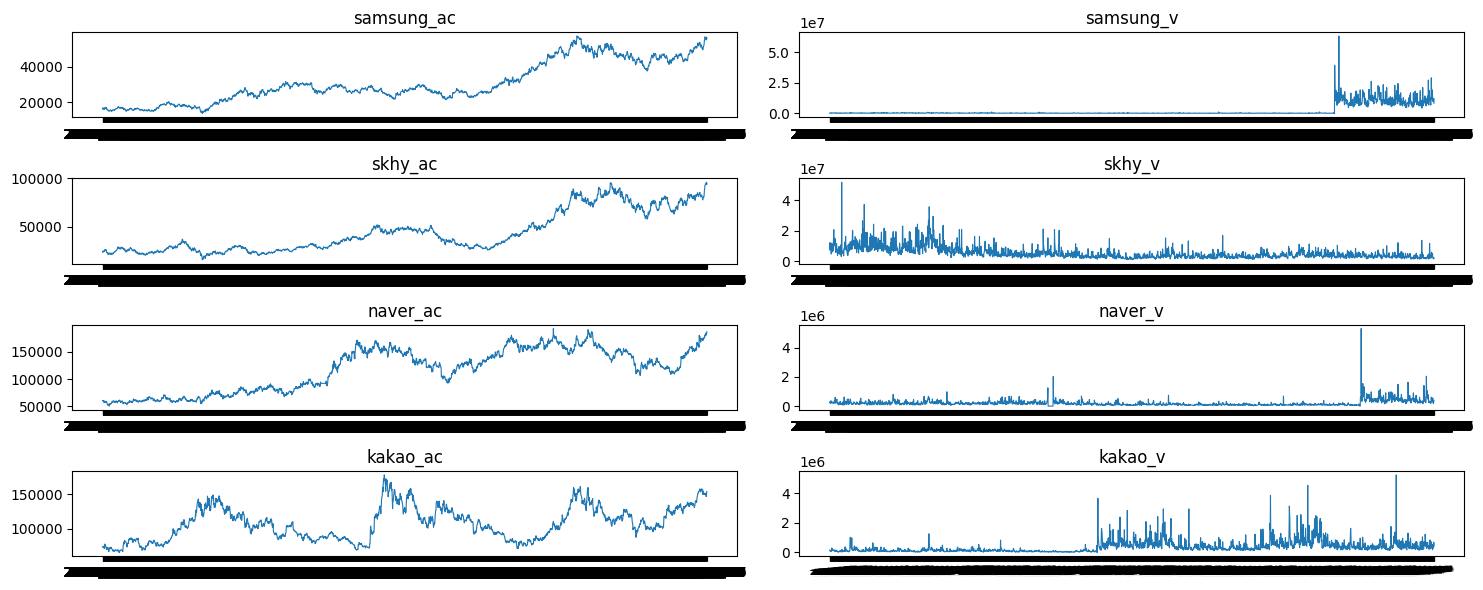

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,6))

ax_li = axes.flatten()
df_cols = df.columns
for i, (col, ax) in enumerate(zip(df_cols, ax_li)):
    ax.plot(df[col], linewidth=0.8)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [24]:
df_cols = df.columns

In [25]:
df_pairs = pd.DataFrame(data=np.zeros((len(df_cols), len(df_cols))),
                        columns = ["X_"+x for x in df_cols],
                        index = ["Y_"+x for x in df_cols])
df_pairs

,X_samsung_ac,X_samsung_v,X_skhy_ac,X_skhy_v,X_naver_ac,X_naver_v,X_kakao_ac,X_kakao_v
Y_samsung_ac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_samsung_v,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_skhy_ac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_skhy_v,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_naver_ac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_naver_v,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_kakao_ac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_kakao_v,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1. Granger Causality

In [26]:
from statsmodels.tsa.stattools import grangercausalitytests

df["kakao_ac"].diff()
sample_outs = grangercausalitytests(df[["kakao_ac","kakao_v"]], maxlag=4) # x가 y를 그랜저 인과
print(sample_outs)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6440  , p=0.1999  , df_denom=2462, df_num=1
ssr based chi2 test:   chi2=1.6460  , p=0.1995  , df=1
likelihood ratio test: chi2=1.6455  , p=0.1996  , df=1
parameter F test:         F=1.6440  , p=0.1999  , df_denom=2462, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9269  , p=0.0537  , df_denom=2459, df_num=2
ssr based chi2 test:   chi2=5.8657  , p=0.0532  , df=2
likelihood ratio test: chi2=5.8588  , p=0.0534  , df=2
parameter F test:         F=2.9269  , p=0.0537  , df_denom=2459, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4979  , p=0.0580  , df_denom=2456, df_num=3
ssr based chi2 test:   chi2=7.5150  , p=0.0572  , df=3
likelihood ratio test: chi2=7.5036  , p=0.0575  , df=3
parameter F test:         F=2.4979  , p=0.0580  , df_denom=2456, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9459  , p=0.

In [27]:
type(sample_outs)

dict

In [28]:
sample_outs.keys()

dict_keys([np.int64(1), np.int64(2), np.int64(3), np.int64(4)])

In [29]:
sample_outs.values()

dict_values([({'ssr_ftest': (np.float64(1.6440099159897197), np.float64(0.19989689535117325), np.float64(2462.0), np.int64(1)), 'ssr_chi2test': (np.float64(1.6460131774633058), np.float64(0.1995024287207972), np.int64(1)), 'lrtest': (np.float64(1.6454638561990578), np.float64(0.1995774506946272), np.int64(1)), 'params_ftest': (np.float64(1.644009915859605), np.float64(0.19989689536897873), np.float64(2462.0), 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x77a5bc751ae0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x77a5bc751ba0>, array([[0., 1., 0.]])]), ({'ssr_ftest': (np.float64(2.9269106691875573), np.float64(0.05374888638075498), np.float64(2459.0), np.int64(2)), 'ssr_chi2test': (np.float64(5.86572418778214), np.float64(0.053244429303113454), np.int64(2)), 'lrtest': (np.float64(5.858753365435405), np.float64(0.053430331817079096), np.int64(2)), 'params_ftest': (np.float64(2.9269106691869595), np.float64(0.05374888638078

In [30]:
# 카이제곱 통계량 사용 - 사건, 범주간의 인과관계가 독립인지 종속인지 검정
# p value는 두번째 값
# p value < 0.05 ? 대립가설(의존적) : 귀무가설(독립적)
sample_outs[1][0]["ssr_chi2test"] 

(np.float64(1.6460131774633058), np.float64(0.1995024287207972), np.int64(1))

In [31]:
[round(sample_outs[x][0]["ssr_chi2test"][1],2) for x in range(1,5)]

[np.float64(0.2), np.float64(0.05), np.float64(0.06), np.float64(0.1)]

In [32]:
maxlag = 14
for col_i, col in enumerate(df_cols):
    for idx_i, idx in enumerate(df_cols):
        outs = grangercausalitytests(df[[col,idx]], maxlag=maxlag)
        pval_min = np.min([round(outs[x][0]["ssr_chi2test"][1],2) for x in range(1, maxlag+1)])
        df_pairs.iloc[idx_i, col_i] = pval_min


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=2463, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1148899.3327, p=0.0000  , df_denom=2463, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=2461, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=574226.9776, p=0.0000  , df_denom=2461, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2459, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=382801.0312, p=0.0000  , df_denom=2459, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.00

In [33]:
df_pairs

,X_samsung_ac,X_samsung_v,X_skhy_ac,X_skhy_v,X_naver_ac,X_naver_v,X_kakao_ac,X_kakao_v
Y_samsung_ac,1.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00
Y_samsung_v,0.01,1.00,0.03,0.00,0.51,0.00,0.37,0.06
Y_skhy_ac,0.01,0.00,1.00,0.00,0.12,0.00,0.03,0.00
Y_skhy_v,0.80,0.00,0.60,1.00,0.41,0.65,0.32,0.00
Y_naver_ac,0.15,0.00,0.04,0.00,1.00,0.00,0.29,0.00
Y_naver_v,0.05,0.00,0.03,0.29,0.01,1.00,0.10,0.00
Y_kakao_ac,0.06,0.00,0.05,0.00,0.62,0.78,1.00,0.00
Y_kakao_v,0.01,0.19,0.20,0.00,0.19,0.00,0.05,1.00


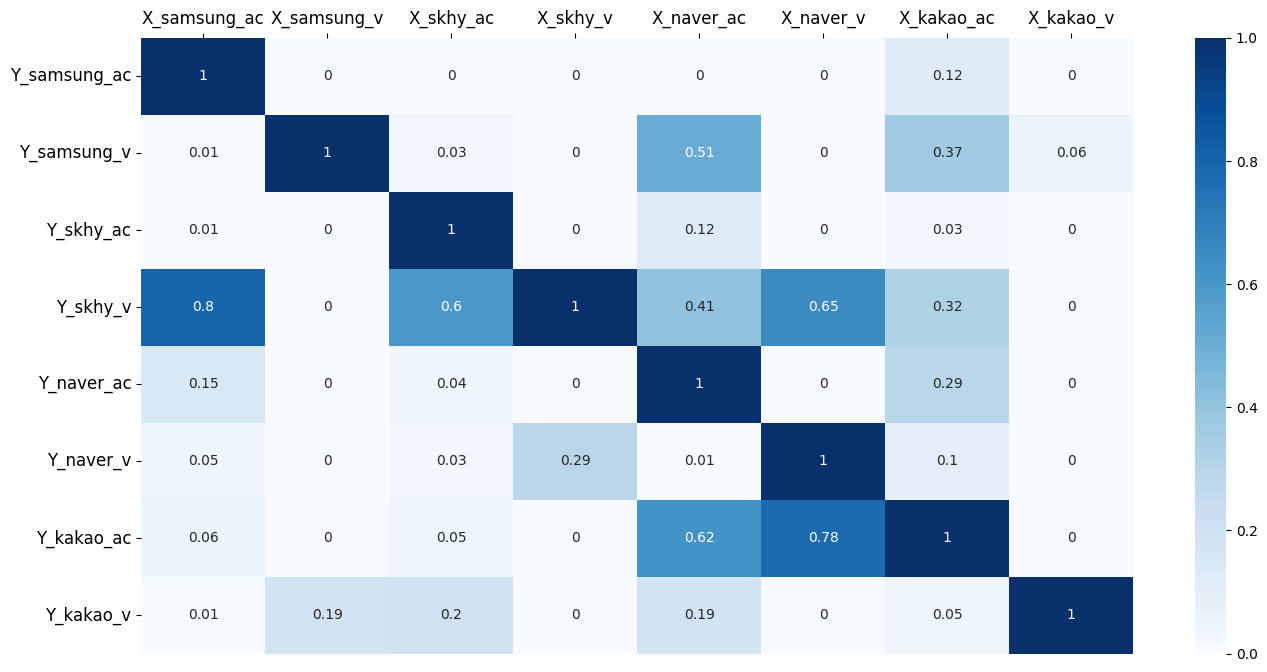

In [34]:
import seaborn as sns

plt.figure(figsize=(16,8))
ax = sns.heatmap(df_pairs, annot=True, cmap="Blues")
ax.xaxis.tick_top()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

2. Cointegration Test

In [35]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

sample_group = ["kakao_ac","kakao_v","naver_ac"]
out = coint_johansen(df[sample_group], 1, 1)
out.lr1

array([427.56347135,  15.67991085,   5.85303086])

In [36]:
cvt_df = pd.DataFrame(out.cvt)
cvt_df.columns = ["90%", "95%", "99%"]
cvt_df.index = sample_group
cvt_df

,90%,95%,99%
kakao_ac,32.0645,35.0116,41.0815
kakao_v,16.1619,18.3985,23.1485
naver_ac,2.7055,3.8415,6.6349


In [37]:
def calc_sig_dist(cols):
    out = coint_johansen(df[cols], 1, 1)
    stats = [round(x,2) for x in out.lr1]
    sigs = [round(x,2) for x in out.cvt[:, 1]]
    yns = [x>y for x,y in zip(stats,sigs)]
    dist = np.mean(np.array(stats) - np.array(sigs))
    

    print("stats: ",stats)
    print("sig-level: ",sigs)
    print("significant_yn: ",[x>y for x,y in zip(stats,sigs)])
    print("dist: ", round(dist,2))

In [38]:
calc_sig_dist(["kakao_ac", "kakao_v", "naver_ac"])

stats:  [np.float64(427.56), np.float64(15.68), np.float64(5.85)]
sig-level:  [np.float64(35.01), np.float64(18.4), np.float64(3.84)]
significant_yn:  [np.True_, np.False_, np.True_]
dist:  130.61


In [39]:
calc_sig_dist(["kakao_ac", "samsung_ac", "skhy_v"])

stats:  [np.float64(435.64), np.float64(15.6), np.float64(6.49)]
sig-level:  [np.float64(35.01), np.float64(18.4), np.float64(3.84)]
significant_yn:  [np.True_, np.False_, np.True_]
dist:  133.49


In [40]:
calc_sig_dist(["skhy_ac", "samsung_v", "kakao_ac"])

stats:  [np.float64(197.78), np.float64(19.82), np.float64(6.58)]
sig-level:  [np.float64(35.01), np.float64(18.4), np.float64(3.84)]
significant_yn:  [np.True_, np.True_, np.True_]
dist:  55.64


In [41]:
target_lag = 30
target_df = df[["skhy_ac","samsung_v","kakao_ac"]]

df_train = target_df.iloc[:-target_lag, :]
df_test = target_df.iloc[-target_lag:, :]

print(df_train.shape, df_test.shape)

(2436, 3) (30, 3)


In [42]:
from statsmodels.tsa.stattools import adfuller

adf_sample = adfuller(df_train["skhy_ac"], autolag="AIC") # AIC가 가장 낮은 lag(시차)를 자동 선택
adf_sample

(np.float64(-0.5807861454903428),
 np.float64(0.8752647354121976),
 1,
 2434,
 {'1%': np.float64(-3.4330394863905473),
  '5%': np.float64(-2.8627281866400818),
  '10%': np.float64(-2.567402520159153)},
 np.float64(40486.58424927438))

In [77]:
adf_df = pd.DataFrame(adf_sample[:4])
adf_df.columns = ["skhy_ac"]
adf_df.index = ["stat","p_value","lag","observ"]

sig = pd.DataFrame(data={"skhy_ac":adf_sample[4]["5%"]}, index=["5%"])
adf_df = pd.concat([adf_df, sig], axis=0)
adf_df

,skhy_ac
stat,-0.580786
p_value,0.875265
lag,1.000000
observ,2434.000000
5%,-2.862728


In [57]:
adf_df.columns

Index(['skhy_ac'], dtype='object')

In [74]:
def get_adf_df(data):
    adf_df = pd.DataFrame(adfuller(data, autolag="AIC")[:4])
    adf_df.columns = [col]
    adf_df.index = ["stat","p_value","lag","observ"]

    sig = pd.DataFrame(data={col:adf_sample[4]["5%"]}, index=["5%"])
    adf_df = pd.concat(objs=[adf_df, sig], axis=0)
    adf_df = adf_df.apply(lambda x : round(x, 2))
    return adf_df

In [75]:
get_adf_df(df_train["kakao_ac"])

,kakao_v
stat,-2.41
p_value,0.14
lag,8.00
observ,2427.00
5%,-2.86


In [46]:
get_adf_df(df_train["samsung_v"])

,kakao_v
stat,-1.69
p_value,0.44
lag,23.00
observ,2412.00
5%,-2.86


In [ ]:
get_adf_df(df_train["kakao_ac"].diff().bfill())

In [ ]:
get_adf_df(df_train["skhy_ac"].diff().bfill())

,kakao_v
stat,-52.13
p_value,0.00
lag,0.00
observ,2435.00
5%,-2.86


In [ ]:
get_adf_df(df_train["samsung_v"].diff().bfill())

,kakao_v
stat,-14.34
p_value,0.00
lag,22.00
observ,2413.00
5%,-2.86


In [ ]:
df_train

,skhy_ac,samsung_v,kakao_ac
일자,,,
2010/01/04,24100,239271,73689
2010/01/05,23350,559219,74291
2010/01/06,24550,459755,74593
2010/01/07,24400,443237,73689
2010/01/08,24650,295798,73187
...,...,...,...
2019/11/11,81300,8185952,154000
2019/11/12,83200,6576148,153500
2019/11/13,83400,6225196,153500


In [ ]:
df_train_ = df_train.copy()
df_train_["skhy_ac_diff"] = df_train["skhy_ac"].diff().bfill()

df_train_

,skhy_ac,samsung_v,kakao_ac,skhy_ac_diff
일자,,,,
2010/01/04,24100,239271,73689,-750.0
2010/01/05,23350,559219,74291,-750.0
2010/01/06,24550,459755,74593,1200.0
2010/01/07,24400,443237,73689,-150.0
2010/01/08,24650,295798,73187,250.0
...,...,...,...,...
2019/11/11,81300,8185952,154000,-1000.0
2019/11/12,83200,6576148,153500,1900.0
2019/11/13,83400,6225196,153500,200.0


In [ ]:
df_train_["samsung_v_diff"] = df_train["samsung_v"].diff().bfill()

df_train_

,skhy_ac,samsung_v,kakao_ac,skhy_ac_diff,samsung_v_diff
일자,,,,,
2010/01/04,24100,239271,73689,-750.0,319948.0
2010/01/05,23350,559219,74291,-750.0,319948.0
2010/01/06,24550,459755,74593,1200.0,-99464.0
2010/01/07,24400,443237,73689,-150.0,-16518.0
2010/01/08,24650,295798,73187,250.0,-147439.0
...,...,...,...,...,...
2019/11/11,81300,8185952,154000,-1000.0,-3417338.0
2019/11/12,83200,6576148,153500,1900.0,-1609804.0
2019/11/13,83400,6225196,153500,200.0,-350952.0


In [ ]:
df_train_.drop(columns=["skhy_ac", "samsung_v"], inplace=True)
df_train_

,kakao_ac,skhy_ac_diff,samsung_v_diff
일자,,,
2010/01/04,73689,-750.0,319948.0
2010/01/05,74291,-750.0,319948.0
2010/01/06,74593,1200.0,-99464.0
2010/01/07,73689,-150.0,-16518.0
2010/01/08,73187,250.0,-147439.0
...,...,...,...
2019/11/11,154000,-1000.0,-3417338.0
2019/11/12,153500,1900.0,-1609804.0
2019/11/13,153500,200.0,-350952.0


In [ ]:
from statsmodels.tsa.api import VAR

var = VAR(df_train_)
var.select_order(maxlags=30).summary()

/home/john/venv/eda_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,63.40,63.41,3.438e+27,63.41
1,58.94,58.97,3.956e+25,58.95
2,58.86,58.91,3.635e+25,58.87
3,58.78,58.85,3.374e+25,58.81
4,58.76,58.85,3.291e+25,58.79
5,58.73,58.85*,3.208e+25,58.77
6,58.72,58.86,3.184e+25,58.77
7,58.72,58.87,3.159e+25,58.77
8,58.71,58.89,3.151e+25,58.78
9,58.70,58.90,3.108e+25,58.77*


In [ ]:
df_train_norm = (df_train_ / df_train_.iloc[0]) - 1
df_train_norm

,kakao_ac,skhy_ac_diff,samsung_v_diff
일자,,,
2010/01/04,0.000000,0.000000,0.000000
2010/01/05,0.008169,0.000000,0.000000
2010/01/06,0.012268,-2.600000,-1.310876
2010/01/07,0.000000,-0.800000,-1.051627
2010/01/08,-0.006812,-1.333333,-1.460822
...,...,...,...
2019/11/11,1.089864,0.333333,-11.680917
2019/11/12,1.083079,-3.533333,-6.031455
2019/11/13,1.083079,-1.266667,-2.096903


In [ ]:
print(get_adf_df(df_train_norm["kakao_ac"]).loc["p_value"])
print(get_adf_df(df_train_norm["skhy_ac_diff"]).loc["p_value"])
print(get_adf_df(df_train_norm["samsung_v_diff"]).loc["p_value"])

kakao_v    0.14
Name: p_value, dtype: float64
kakao_v    0.0
Name: p_value, dtype: float64
kakao_v    0.0
Name: p_value, dtype: float64


In [ ]:
var_norm = VAR(df_train_norm)
var_norm.select_order(maxlags=20).summary()

/home/john/venv/eda_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,2.397,2.404,10.99,2.400
1,-2.077,-2.048,0.1254,-2.066
2,-2.161,-2.111,0.1152,-2.143
3,-2.236,-2.164,0.1069,-2.210
4,-2.261,-2.167,0.1043,-2.227
5,-2.286,-2.171*,0.1017,-2.244
6,-2.294,-2.157,0.1009,-2.244
7,-2.302,-2.144,0.1001,-2.244
8,-2.304,-2.125,0.09981,-2.239
9,-2.318,-2.117,0.09843,-2.245*


In [ ]:
model = var_norm.fit(20)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Mar, 2025
Time:                     15:11:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.92717
Nobs:                     2416.00    HQIC:                  -2.20623
Log likelihood:          -7243.68    FPE:                  0.0938848
AIC:                     -2.36572    Det(Omega_mle):       0.0871180
--------------------------------------------------------------------
Results for equation kakao_ac
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.002480         0.003780           -0.656           0.512
L1.kakao_ac                1.015558         0.020863           48.677           0.000
L1.skhy_ac_diff            0.000381  

In [ ]:
model.resid.corr()

,kakao_ac,skhy_ac_diff,samsung_v_diff
kakao_ac,1.000000,-0.160134,-0.014358
skhy_ac_diff,-0.160134,1.000000,0.032727
samsung_v_diff,-0.014358,0.032727,1.000000


In [ ]:
from statsmodels.stats.stattools import durbin_watson

durbin_res = pd.DataFrame([model.resid.columns, 
                           [round(x,2) for x in durbin_watson(model.resid)]]).T
durbin_res.set_index([0])

,1
0,
kakao_ac,2.0
skhy_ac_diff,2.0
samsung_v_diff,1.99


In [ ]:
model.k_ar

20

In [ ]:
ins = df_train_norm.values[-model.k_ar:]
ins

array([[  0.81166796,  -1.13333333, -13.74136735],
       [  0.84559432,  -3.13333333,  19.29141611],
       [  0.89987651,   0.86666667,  -7.98503819],
       [  0.89309123,  -4.06666667,  38.13731294],
       [  0.89987651,  -4.86666667, -42.58765799],
       [  0.89987651,  -1.        ,  -5.5269075 ],
       [  0.89309123,  -1.13333333,   2.59466851],
       [  0.87273542,   1.        ,   3.30634353],
       [  0.92023233,  -1.66666667,   3.20487704],
       [  0.97451451,  -2.46666667,  -6.74134234],
       [  0.98808506,  -3.13333333,  13.20407379],
       [  1.01522615,  -1.53333333,  -8.59928801],
       [  1.04915252,   1.13333333,  10.81472927],
       [  1.04915252,  -1.13333333, -16.95264543],
       [  1.06272307,   0.73333333,   6.33298536],
       [  1.08986416,   0.33333333, -11.6809169 ],
       [  1.08307889,  -3.53333333,  -6.03145511],
       [  1.08307889,  -1.26666667,  -2.09690325],
       [  1.09664943,  -1.        ,  17.08050683],
       [  1.11021998,  -3.4    

In [ ]:
f = model.forecast(y=ins, steps=7)
df_f = pd.DataFrame(f, columns=df_train_norm.columns)
df_f

,kakao_ac,skhy_ac_diff,samsung_v_diff
0,1.109996,0.146525,6.522486
1,1.106270,-0.741351,-13.782188
2,1.097559,-0.672040,3.140202
3,1.093781,-1.329530,-1.890650
4,1.094226,-1.386561,0.434419
5,1.093290,-0.978438,-1.647137
6,1.099563,-1.013445,0.345241


In [ ]:
df_train_.iloc[0]

kakao_ac           73689.0
skhy_ac_diff        -750.0
samsung_v_diff    319948.0
Name: 2010/01/04, dtype: float64

In [ ]:
df_f_denorm = (df_f + 1).mul(df_train_.iloc[0].to_numpy())
df_f_denorm

,kakao_ac,skhy_ac_diff,samsung_v_diff
0,155483.471167,-859.893965,2.406804e+06
1,155208.954878,-193.986679,-4.089636e+06
2,154567.051200,-245.970205,1.324649e+06
3,154288.621793,247.147801,-2.849618e+05
4,154321.445043,289.920930,4.589394e+05
5,154252.437976,-16.171796,-2.070503e+05
6,154714.678162,10.083619,4.304072e+05


In [ ]:
df_train["skhy_ac"].iloc[-1]

np.int64(85200)

In [ ]:
df_f_denorm["samsung_v"] = np.r_[df_train["samsung_v"].iloc[-1],
                                 df_f_denorm["samsung_v_diff"]].cumsum()[1:]

In [ ]:
df_f_denorm["skhy_ac"] = np.r_[df_train["skhy_ac"].iloc[-1],
                                 df_f_denorm["skhy_ac_diff"]].cumsum()[1:]

In [ ]:
df_f_denorm

,kakao_ac,skhy_ac_diff,samsung_v_diff,samsung_v,skhy_ac
0,155483.471167,-859.893965,2.406804e+06,1.211016e+07,84340.106035
1,155208.954878,-193.986679,-4.089636e+06,8.020529e+06,84146.119356
2,154567.051200,-245.970205,1.324649e+06,9.345178e+06,83900.149150
3,154288.621793,247.147801,-2.849618e+05,9.060216e+06,84147.296952
4,154321.445043,289.920930,4.589394e+05,9.519156e+06,84437.217882
5,154252.437976,-16.171796,-2.070503e+05,9.312105e+06,84421.046086
6,154714.678162,10.083619,4.304072e+05,9.742513e+06,84431.129705


In [ ]:
df_f_denorm.index = df_test.index[:7]
df_f_denorm

,kakao_ac,skhy_ac_diff,samsung_v_diff,samsung_v,skhy_ac
일자,,,,,
2019/11/18,155483.471167,-859.893965,2.406804e+06,1.211016e+07,84340.106035
2019/11/19,155208.954878,-193.986679,-4.089636e+06,8.020529e+06,84146.119356
2019/11/20,154567.051200,-245.970205,1.324649e+06,9.345178e+06,83900.149150
2019/11/21,154288.621793,247.147801,-2.849618e+05,9.060216e+06,84147.296952
2019/11/22,154321.445043,289.920930,4.589394e+05,9.519156e+06,84437.217882
2019/11/25,154252.437976,-16.171796,-2.070503e+05,9.312105e+06,84421.046086
2019/11/26,154714.678162,10.083619,4.304072e+05,9.742513e+06,84431.129705


In [ ]:
def draw_subplot(axes, ax_i, col):
    d_test = df_test[col].iloc[:7]
    d_pred = df_f_denorm[col]
    
    d_test.diff() > 0
    
    axes[ax_i].plot(d_test, label="real")
    axes[ax_i].plot(d_pred, label="pred")
    
    hits = (d_test.diff() < 0) == (d_pred.diff() < 0)
    for i, hit in enumerate(hits):
        if hit:
            if i==0:
                pass
            if i+1==len(hits):
                i==None
            axes[ax_i].fill_between(x=d_test.index[i-1:i+1], 
                                    y1=d_pred[i-1:i+1],
                                    y2=d_test[i-1:i+1], 
                                    color="lightpink", 
                                    alpha=0.1)       
    axes[ax_i].set_title(col)
    axes[ax_i].legend(loc=(1,1))


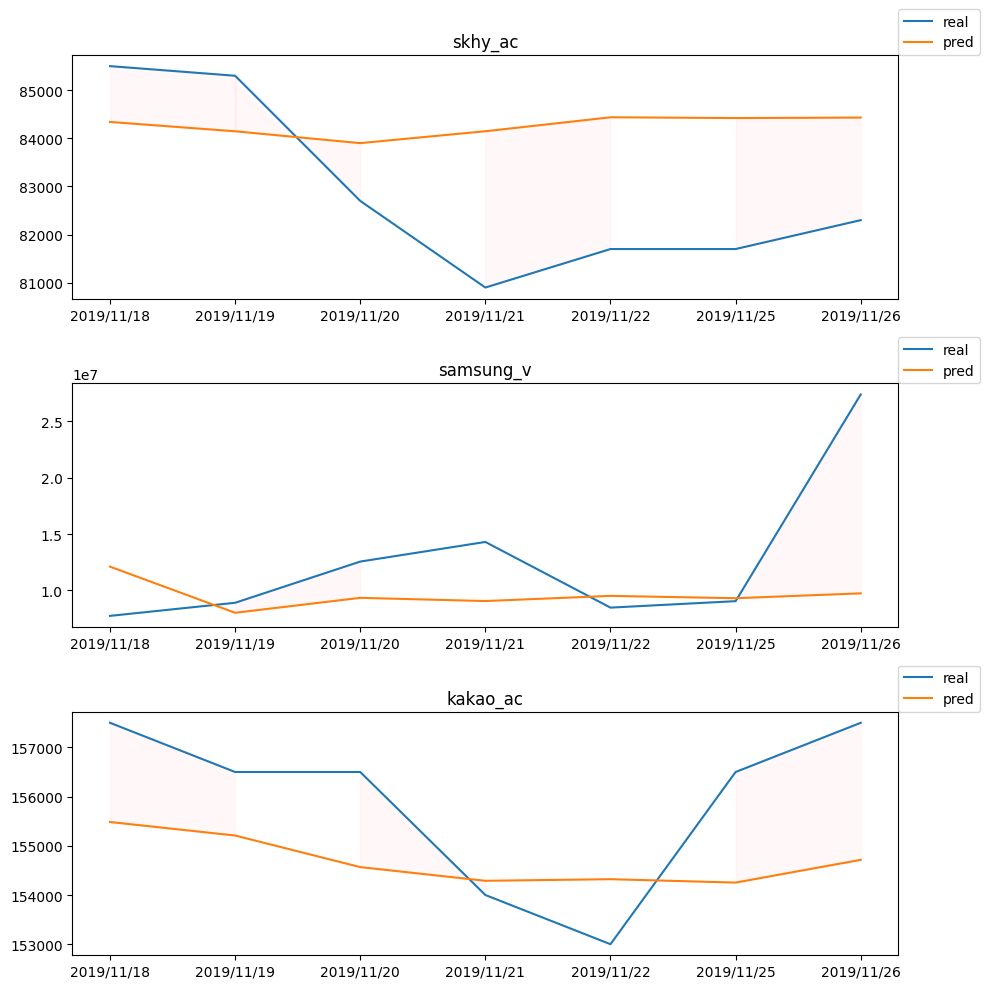

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

draw_subplot(axes, 0, "skhy_ac")
draw_subplot(axes, 1, "samsung_v")
draw_subplot(axes, 2, "kakao_ac")

plt.tight_layout()
plt.show()